#  Examples and Figures Used for Manuscript

pyMCR is a small package for performing multivariate curve resolution. Currently, it implements a simple alternating regression (MCR-AR) scheme. When the regressors are ordinary least-squares, this is MCR-alternating least-squares (MCR-ALS).


**MCR assumes a system of the form: D = CS^T**
    
Data that you will provide (hyperspectral context):
    
`D [n_pixels, n_frequencies]  # Hyperspectral image unraveled in space (2D)`
    
`initial_spectra [n_components, n_frequencies]  ## S^T in the literature`
    
OR

`initial_conc [n_pixels, n_components]   ## C in the literature`

If you have an initial estimate of the spectra

`mcrar.fit(D, ST=initial_spectra)`

Otherwise, if you have an initial estimate of the concentrations

`mcrar.fit(D, C=initial_conc)`

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8

# importing pymcr pieces
from pymcr.mcr import McrAR
from pymcr.regressors import OLS, NNLS
from pymcr.constraints import ConstraintNonneg, ConstraintNorm

from sklearn.linear_model.ridge import Ridge

# Define model system

## Initial spectal components

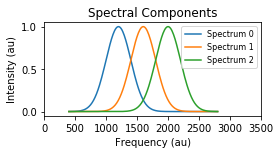

In [2]:
wn = np.linspace(400,2800,200)

n_components = 3

sp0 = np.exp(-(wn-1200)**2/(2*200**2))
sp1 = np.exp(-(wn-1600)**2/(2*200**2))
sp2 = np.exp(-(wn-2000)**2/(2*200**2))

plt.figure(figsize=[4,2.25])
plt.plot(wn, sp0, label='Spectrum 0')
plt.plot(wn, sp1, label='Spectrum 1')
plt.plot(wn, sp2, label='Spectrum 2')
plt.xlabel('Frequency (au)')
plt.ylabel('Intensity (au)')
plt.legend(loc='best')
plt.title('Spectral Components')
plt.axis(xmin=0, xmax=3500)
plt.tight_layout()
plt.savefig('NJRes_Model_Spectra.eps')

## Concentration map

Model starts off as 3 2D-Gaussian centered at (x*, y*) with standard deviation R (1 for each component).

The sum to 1 constraint is then enforced.

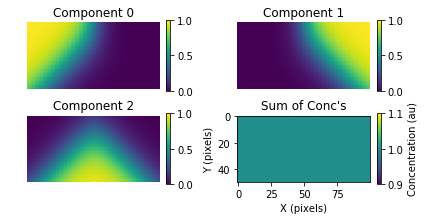

In [57]:
x0 = 10
y0 = 10

x1 = 90
y1 = 10

x2 = 50
y2 = 50

R0 = 20
R1 = 20
R2 = 20

M=50  # rows (Y)
N= 100  # cols (X)

# Init concentration map
conc = np.zeros((M,N,n_components))

X,Y = np.meshgrid(np.arange(N), np.arange(M))

conc[...,0] = np.exp(-(X-x0)**2/(2*R0**2))*np.exp(-(Y-y0)**2/(2*R0**2))
conc[...,1] = np.exp(-(X-x1)**2/(2*R1**2))*np.exp(-(Y-y1)**2/(2*R1**2))
conc[...,2] = np.exp(-(X-x2)**2/(2*R2**2))*np.exp(-(Y-y2)**2/(2*R2**2))

conc /= conc.sum(axis=-1)[:,:,None]

# Find the maximum concentration (per component)
# and set to conc = 1 (and make the rest 0's)
# This just ensures that each component has a pure
# pixel somewhere within the image
for num in range(n_components):
    idx_m, idx_n = np.where(conc[..., num] >= 0.999 * conc[..., num].max())
    conc[idx_m, idx_n, :] = 0
    conc[idx_m, idx_n, num] = 1
conc /= conc.sum(axis=-1)[:,:,None]
#     idx = np.unravel_index(conc[...,num].argmax(), conc[...,num].shape)
#     tmp = np.zeros(3)
#     tmp[num] = 1
#     conc[idx[0],idx[1],:] = 1*tmp

plt.figure(figsize=(6,3.5))
for num in range(3):
    plt.subplot(2,2,num+1)
    plt.imshow(conc[...,num])
    plt.colorbar(fraction=0.025)
    plt.axis('off')
    plt.title('Component {}'.format(num))

plt.subplot(2,2,4)
plt.imshow(conc.sum(axis=-1))
plt.colorbar(fraction=0.025, label='Concentration (au)')
# plt.axis('off')
plt.title('Sum of Conc\'s')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.tight_layout(h_pad=-3)
plt.savefig('NJRes_Model_Conc.eps')

In [4]:
# Stack 3 spectral vectors into 1 matrix
spectra = np.vstack((sp0, sp1, sp2))

# Hyperspectral image (HSI)
hsi = np.dot(conc, spectra)

# Perform MCR-AR (OLS) with Non-Negativity and Sum-to-One Constraints

## With spectral guess

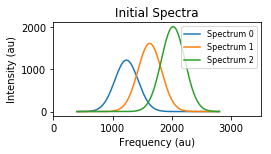

In [5]:
# Poor guess
initial_spectra = spectra*wn

# plt.figure(figsize=(4,6))
# plt.subplot(211)
# plt.plot(wn, spectra.T)
# plt.xlabel('Frequency (au)')
# plt.ylabel('Intensity (au)')
# plt.title('Actual')

# plt.subplot(212)
# plt.plot(wn, initial_spectra.T)
# plt.xlabel('Frequency (au)')
# plt.ylabel('Intensity (au)')
# plt.title('Initial Guess')

plt.figure(figsize=[4,2.25])
plt.plot(wn, initial_spectra[0,:], label='Spectrum 0')
plt.plot(wn, initial_spectra[1,:], label='Spectrum 1')
plt.plot(wn, initial_spectra[2,:], label='Spectrum 2')
plt.xlabel('Frequency (au)')
plt.ylabel('Intensity (au)')
lgd = plt.legend(loc='best')

plt.title('Initial Spectra')
plt.axis(xmin=0, xmax=3500)
plt.tight_layout()
plt.savefig('NJRes_Spectra_Guess.eps')

In [6]:
mcrar = McrAR(max_iter=1000, st_regr='OLS', c_regr='OLS', 
              c_constraints=[ConstraintNonneg(), ConstraintNorm()],
              st_constraints=[ConstraintNonneg()])

mcrar.fit(hsi.reshape((-1, wn.size)), ST=initial_spectra, verbose=True)
print('\nFinal MSE: {:.7e}'.format(mcrar.err[-1]))


Iter: 1 (C)	mse: 2.7109e+05
Iter: 1 (ST)	mse: 4.6743e-04
Iter: 2 (C)	mse: 1.3978e-04
Iter: 2 (ST)	mse: 6.3675e-05
Iter: 3 (C)	mse: 4.3701e-05
Iter: 3 (ST)	mse: 3.1687e-05
Iter: 4 (C)	mse: 2.4658e-05
Iter: 4 (ST)	mse: 1.9290e-05
Iter: 5 (C)	mse: 1.5586e-05
Iter: 5 (ST)	mse: 1.2725e-05
Iter: 6 (C)	mse: 1.0536e-05
Iter: 6 (ST)	mse: 8.8708e-06
Iter: 7 (C)	mse: 7.4881e-06
Iter: 7 (ST)	mse: 6.4611e-06
Iter: 8 (C)	mse: 5.5418e-06
Iter: 8 (ST)	mse: 4.8794e-06
Iter: 9 (C)	mse: 4.2444e-06
Iter: 9 (ST)	mse: 3.8008e-06
Iter: 10 (C)	mse: 3.3437e-06
Iter: 10 (ST)	mse: 3.0357e-06
Iter: 11 (C)	mse: 2.6981e-06
Iter: 11 (ST)	mse: 2.4789e-06
Iter: 12 (C)	mse: 2.2227e-06
Iter: 12 (ST)	mse: 2.0627e-06
Iter: 13 (C)	mse: 1.8629e-06
Iter: 13 (ST)	mse: 1.7431e-06
Iter: 14 (C)	mse: 1.5846e-06
Iter: 14 (ST)	mse: 1.4933e-06
Iter: 15 (C)	mse: 1.3655e-06
Iter: 15 (ST)	mse: 1.2952e-06
Iter: 16 (C)	mse: 1.1907e-06
Iter: 16 (ST)	mse: 1.1351e-06
Iter: 17 (C)	mse: 1.0480e-06
Iter: 17 (ST)	mse: 1.0035e-06
Iter: 18 (C)	ms

# Plotting the results

<Figure size 432x288 with 0 Axes>

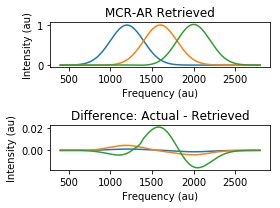

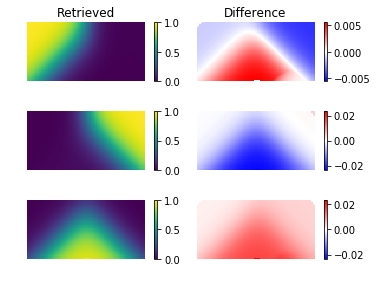

In [7]:
plt.figure(figsize=(6,4))
# plt.subplot(221)
# plt.plot(wn, initial_spectra.T)
# plt.xlabel('Frequency (au)')
# plt.ylabel('Intensity (au)')
# plt.title('Initial Guess')

# plt.subplot(222)
# plt.plot(wn, spectra.T)
# plt.xlabel('Frequency (au)')
# plt.ylabel('Intensity (au)')
# plt.title('Actual')

plt.figure(figsize=(4,3))
plt.subplot(211)
plt.plot(wn, mcrar.ST_opt_.T)
plt.xlabel('Frequency (au)')
plt.ylabel('Intensity (au)')
plt.title('MCR-AR Retrieved')

plt.subplot(212)
plt.plot(wn, spectra.T - mcrar.ST_opt_.T)
plt.xlabel('Frequency (au)')
plt.ylabel('Intensity (au)')
plt.title('Difference: Actual - Retrieved')

plt.tight_layout()
plt.savefig('NJRes_OLS_OLS_Spectra.eps')
plt.show()

temp = mcrar.C_opt_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,2,2*num+1)
    
#     plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num], clim=[0,1])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,2,2*num+2)
    temp_differ = conc[...,num] - temp[...,num]
    temp_max_differ = np.abs(temp_differ).max()
    plt.imshow(temp_differ, cmap='bwr', clim=[-temp_max_differ, temp_max_differ])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')

plt.tight_layout(w_pad=-5)
plt.savefig('NJRes_OLS_OLS_Conc.eps')
plt.show()

# Perform MCR-AR (NNLS) with Non-Negativity and Sum-to-One Constraints

## With spectral guess

In [8]:
mcrar = McrAR(max_iter=1000, st_regr='NNLS', c_regr='NNLS', 
              c_constraints=[ConstraintNorm()],
              st_constraints=[])

mcrar.fit(hsi.reshape((-1, wn.size)), ST=initial_spectra, verbose=True)
print('\nFinal MSE: {:.7e}'.format(mcrar.err[-1]))


Iter: 1 (C)	mse: 2.7181e+05
Iter: 1 (ST)	mse: 4.0381e-04
Iter: 2 (C)	mse: 1.5740e-04
Iter: 2 (ST)	mse: 8.5882e-05
Iter: 3 (C)	mse: 6.4110e-05
Iter: 3 (ST)	mse: 4.6620e-05
Iter: 4 (C)	mse: 3.7472e-05
Iter: 4 (ST)	mse: 2.9234e-05
Iter: 5 (C)	mse: 2.4333e-05
Iter: 5 (ST)	mse: 1.9644e-05
Iter: 6 (C)	mse: 1.6725e-05
Iter: 6 (ST)	mse: 1.3839e-05
Iter: 7 (C)	mse: 1.1989e-05
Iter: 7 (ST)	mse: 1.0111e-05
Iter: 8 (C)	mse: 8.8830e-06
Iter: 8 (ST)	mse: 7.6077e-06
Iter: 9 (C)	mse: 6.7579e-06
Iter: 9 (ST)	mse: 5.8657e-06
Iter: 10 (C)	mse: 5.2610e-06
Iter: 10 (ST)	mse: 4.6181e-06
Iter: 11 (C)	mse: 4.1754e-06
Iter: 11 (ST)	mse: 3.7029e-06
Iter: 12 (C)	mse: 3.3720e-06
Iter: 12 (ST)	mse: 3.0179e-06
Iter: 13 (C)	mse: 2.7649e-06
Iter: 13 (ST)	mse: 2.4948e-06
Iter: 14 (C)	mse: 2.2989e-06
Iter: 14 (ST)	mse: 2.0894e-06
Iter: 15 (C)	mse: 1.9345e-06
Iter: 15 (ST)	mse: 1.7702e-06
Iter: 16 (C)	mse: 1.6466e-06
Iter: 16 (ST)	mse: 1.5157e-06
Iter: 17 (C)	mse: 1.4156e-06
Iter: 17 (ST)	mse: 1.3099e-06
Iter: 18 (C)	ms

Iter: 139 (C)	mse: 2.0522e-08
Iter: 139 (ST)	mse: 2.0400e-08
Iter: 140 (C)	mse: 2.0280e-08
Iter: 140 (ST)	mse: 2.0160e-08
Iter: 141 (C)	mse: 2.0041e-08
Iter: 141 (ST)	mse: 1.9924e-08
Iter: 142 (C)	mse: 1.9807e-08
Iter: 142 (ST)	mse: 1.9691e-08
Iter: 143 (C)	mse: 1.9577e-08
Iter: 143 (ST)	mse: 1.9463e-08
Iter: 144 (C)	mse: 1.9350e-08
Iter: 144 (ST)	mse: 1.9239e-08
Iter: 145 (C)	mse: 1.9128e-08
Iter: 145 (ST)	mse: 1.9018e-08
Iter: 146 (C)	mse: 1.8909e-08
Iter: 146 (ST)	mse: 1.8801e-08
Iter: 147 (C)	mse: 1.8693e-08
Iter: 147 (ST)	mse: 1.8587e-08
Iter: 148 (C)	mse: 1.8482e-08
Iter: 148 (ST)	mse: 1.8377e-08
Iter: 149 (C)	mse: 1.8273e-08
Iter: 149 (ST)	mse: 1.8171e-08
Iter: 150 (C)	mse: 1.8068e-08
Iter: 150 (ST)	mse: 1.7967e-08
Iter: 151 (C)	mse: 1.7867e-08
Iter: 151 (ST)	mse: 1.7767e-08
Iter: 152 (C)	mse: 1.7668e-08
Iter: 152 (ST)	mse: 1.7571e-08
Iter: 153 (C)	mse: 1.7474e-08
Iter: 153 (ST)	mse: 1.7377e-08
Iter: 154 (C)	mse: 1.7282e-08
Iter: 154 (ST)	mse: 1.7187e-08
Iter: 155 (C)	mse: 1.709

Iter: 274 (C)	mse: 6.0876e-09
Iter: 274 (ST)	mse: 6.0672e-09
Iter: 275 (C)	mse: 6.0466e-09
Iter: 275 (ST)	mse: 6.0265e-09
Iter: 276 (C)	mse: 6.0061e-09
Iter: 276 (ST)	mse: 5.9862e-09
Iter: 277 (C)	mse: 5.9660e-09
Iter: 277 (ST)	mse: 5.9464e-09
Iter: 278 (C)	mse: 5.9264e-09
Iter: 278 (ST)	mse: 5.9069e-09
Iter: 279 (C)	mse: 5.8872e-09
Iter: 279 (ST)	mse: 5.8679e-09
Iter: 280 (C)	mse: 5.8484e-09
Iter: 280 (ST)	mse: 5.8294e-09
Iter: 281 (C)	mse: 5.8100e-09
Iter: 281 (ST)	mse: 5.7912e-09
Iter: 282 (C)	mse: 5.7721e-09
Iter: 282 (ST)	mse: 5.7535e-09
Iter: 283 (C)	mse: 5.7345e-09
Iter: 283 (ST)	mse: 5.7162e-09
Iter: 284 (C)	mse: 5.6974e-09
Iter: 284 (ST)	mse: 5.6792e-09
Iter: 285 (C)	mse: 5.6607e-09
Iter: 285 (ST)	mse: 5.6427e-09
Iter: 286 (C)	mse: 5.6243e-09
Iter: 286 (ST)	mse: 5.6066e-09
Iter: 287 (C)	mse: 5.5884e-09
Iter: 287 (ST)	mse: 5.5709e-09
Iter: 288 (C)	mse: 5.5529e-09
Iter: 288 (ST)	mse: 5.5355e-09
Iter: 289 (C)	mse: 5.5177e-09
Iter: 289 (ST)	mse: 5.5006e-09
Iter: 290 (C)	mse: 5.482

Iter: 409 (C)	mse: 3.0413e-09
Iter: 409 (ST)	mse: 3.0359e-09
Iter: 410 (C)	mse: 3.0295e-09
Iter: 410 (ST)	mse: 3.0241e-09
Iter: 411 (C)	mse: 3.0178e-09
Iter: 411 (ST)	mse: 3.0124e-09
Iter: 412 (C)	mse: 3.0061e-09
Iter: 412 (ST)	mse: 3.0008e-09
Iter: 413 (C)	mse: 2.9945e-09
Iter: 413 (ST)	mse: 2.9892e-09
Iter: 414 (C)	mse: 2.9830e-09
Iter: 414 (ST)	mse: 2.9778e-09
Iter: 415 (C)	mse: 2.9716e-09
Iter: 415 (ST)	mse: 2.9664e-09
Iter: 416 (C)	mse: 2.9603e-09
Iter: 416 (ST)	mse: 2.9552e-09
Iter: 417 (C)	mse: 2.9491e-09
Iter: 417 (ST)	mse: 2.9440e-09
Iter: 418 (C)	mse: 2.9379e-09
Iter: 418 (ST)	mse: 2.9328e-09
Iter: 419 (C)	mse: 2.9268e-09
Iter: 419 (ST)	mse: 2.9218e-09
Iter: 420 (C)	mse: 2.9158e-09
Iter: 420 (ST)	mse: 2.9109e-09
Iter: 421 (C)	mse: 2.9049e-09
Iter: 421 (ST)	mse: 2.9000e-09
Iter: 422 (C)	mse: 2.8941e-09
Iter: 422 (ST)	mse: 2.8892e-09
Iter: 423 (C)	mse: 2.8833e-09
Iter: 423 (ST)	mse: 2.8785e-09
Iter: 424 (C)	mse: 2.8727e-09
Iter: 424 (ST)	mse: 2.8678e-09
Iter: 425 (C)	mse: 2.862

Iter: 544 (C)	mse: 2.0088e-09
Iter: 544 (ST)	mse: 2.0069e-09
Iter: 545 (C)	mse: 2.0039e-09
Iter: 545 (ST)	mse: 2.0020e-09
Iter: 546 (C)	mse: 1.9990e-09
Iter: 546 (ST)	mse: 1.9971e-09
Iter: 547 (C)	mse: 1.9941e-09
Iter: 547 (ST)	mse: 1.9922e-09
Iter: 548 (C)	mse: 1.9892e-09
Iter: 548 (ST)	mse: 1.9873e-09
Iter: 549 (C)	mse: 1.9843e-09
Iter: 549 (ST)	mse: 1.9825e-09
Iter: 550 (C)	mse: 1.9795e-09
Iter: 550 (ST)	mse: 1.9777e-09
Iter: 551 (C)	mse: 1.9747e-09
Iter: 551 (ST)	mse: 1.9729e-09
Iter: 552 (C)	mse: 1.9699e-09
Iter: 552 (ST)	mse: 1.9681e-09
Iter: 553 (C)	mse: 1.9652e-09
Iter: 553 (ST)	mse: 1.9633e-09
Iter: 554 (C)	mse: 1.9604e-09
Iter: 554 (ST)	mse: 1.9586e-09
Iter: 555 (C)	mse: 1.9557e-09
Iter: 555 (ST)	mse: 1.9539e-09
Iter: 556 (C)	mse: 1.9510e-09
Iter: 556 (ST)	mse: 1.9492e-09
Iter: 557 (C)	mse: 1.9463e-09
Iter: 557 (ST)	mse: 1.9446e-09
Iter: 558 (C)	mse: 1.9417e-09
Iter: 558 (ST)	mse: 1.9399e-09
Iter: 559 (C)	mse: 1.9371e-09
Iter: 559 (ST)	mse: 1.9353e-09
Iter: 560 (C)	mse: 1.932

Iter: 679 (C)	mse: 1.5072e-09
Iter: 679 (ST)	mse: 1.5062e-09
Iter: 680 (C)	mse: 1.5044e-09
Iter: 680 (ST)	mse: 1.5035e-09
Iter: 681 (C)	mse: 1.5017e-09
Iter: 681 (ST)	mse: 1.5007e-09
Iter: 682 (C)	mse: 1.4990e-09
Iter: 682 (ST)	mse: 1.4980e-09
Iter: 683 (C)	mse: 1.4962e-09
Iter: 683 (ST)	mse: 1.4953e-09
Iter: 684 (C)	mse: 1.4935e-09
Iter: 684 (ST)	mse: 1.4926e-09
Iter: 685 (C)	mse: 1.4908e-09
Iter: 685 (ST)	mse: 1.4899e-09
Iter: 686 (C)	mse: 1.4881e-09
Iter: 686 (ST)	mse: 1.4872e-09
Iter: 687 (C)	mse: 1.4855e-09
Iter: 687 (ST)	mse: 1.4845e-09
Iter: 688 (C)	mse: 1.4828e-09
Iter: 688 (ST)	mse: 1.4818e-09
Iter: 689 (C)	mse: 1.4801e-09
Iter: 689 (ST)	mse: 1.4792e-09
Iter: 690 (C)	mse: 1.4775e-09
Iter: 690 (ST)	mse: 1.4766e-09
Iter: 691 (C)	mse: 1.4749e-09
Iter: 691 (ST)	mse: 1.4739e-09
Iter: 692 (C)	mse: 1.4722e-09
Iter: 692 (ST)	mse: 1.4713e-09
Iter: 693 (C)	mse: 1.4696e-09
Iter: 693 (ST)	mse: 1.4687e-09
Iter: 694 (C)	mse: 1.4670e-09
Iter: 694 (ST)	mse: 1.4661e-09
Iter: 695 (C)	mse: 1.464

Iter: 814 (C)	mse: 1.2140e-09
Iter: 814 (ST)	mse: 1.2134e-09
Iter: 815 (C)	mse: 1.2122e-09
Iter: 815 (ST)	mse: 1.2116e-09
Iter: 816 (C)	mse: 1.2105e-09
Iter: 816 (ST)	mse: 1.2099e-09
Iter: 817 (C)	mse: 1.2088e-09
Iter: 817 (ST)	mse: 1.2082e-09
Iter: 818 (C)	mse: 1.2071e-09
Iter: 818 (ST)	mse: 1.2065e-09
Iter: 819 (C)	mse: 1.2053e-09
Iter: 819 (ST)	mse: 1.2048e-09
Iter: 820 (C)	mse: 1.2036e-09
Iter: 820 (ST)	mse: 1.2030e-09
Iter: 821 (C)	mse: 1.2019e-09
Iter: 821 (ST)	mse: 1.2013e-09
Iter: 822 (C)	mse: 1.2002e-09
Iter: 822 (ST)	mse: 1.1996e-09
Iter: 823 (C)	mse: 1.1985e-09
Iter: 823 (ST)	mse: 1.1980e-09
Iter: 824 (C)	mse: 1.1969e-09
Iter: 824 (ST)	mse: 1.1963e-09
Iter: 825 (C)	mse: 1.1952e-09
Iter: 825 (ST)	mse: 1.1946e-09
Iter: 826 (C)	mse: 1.1935e-09
Iter: 826 (ST)	mse: 1.1929e-09
Iter: 827 (C)	mse: 1.1918e-09
Iter: 827 (ST)	mse: 1.1912e-09
Iter: 828 (C)	mse: 1.1902e-09
Iter: 828 (ST)	mse: 1.1896e-09
Iter: 829 (C)	mse: 1.1885e-09
Iter: 829 (ST)	mse: 1.1879e-09
Iter: 830 (C)	mse: 1.186

Iter: 948 (ST)	mse: 1.0182e-09
Iter: 949 (C)	mse: 1.0174e-09
Iter: 949 (ST)	mse: 1.0170e-09
Iter: 950 (C)	mse: 1.0162e-09
Iter: 950 (ST)	mse: 1.0158e-09
Iter: 951 (C)	mse: 1.0150e-09
Iter: 951 (ST)	mse: 1.0146e-09
Iter: 952 (C)	mse: 1.0137e-09
Iter: 952 (ST)	mse: 1.0133e-09
Iter: 953 (C)	mse: 1.0125e-09
Iter: 953 (ST)	mse: 1.0121e-09
Iter: 954 (C)	mse: 1.0113e-09
Iter: 954 (ST)	mse: 1.0109e-09
Iter: 955 (C)	mse: 1.0101e-09
Iter: 955 (ST)	mse: 1.0097e-09
Iter: 956 (C)	mse: 1.0089e-09
Iter: 956 (ST)	mse: 1.0085e-09
Iter: 957 (C)	mse: 1.0077e-09
Iter: 957 (ST)	mse: 1.0073e-09
Iter: 958 (C)	mse: 1.0065e-09
Iter: 958 (ST)	mse: 1.0061e-09
Iter: 959 (C)	mse: 1.0053e-09
Iter: 959 (ST)	mse: 1.0049e-09
Iter: 960 (C)	mse: 1.0041e-09
Iter: 960 (ST)	mse: 1.0038e-09
Iter: 961 (C)	mse: 1.0030e-09
Iter: 961 (ST)	mse: 1.0026e-09
Iter: 962 (C)	mse: 1.0018e-09
Iter: 962 (ST)	mse: 1.0014e-09
Iter: 963 (C)	mse: 1.0006e-09
Iter: 963 (ST)	mse: 1.0002e-09
Iter: 964 (C)	mse: 9.9942e-10
Iter: 964 (ST)	mse: 9.99

## Plotting the Results

<Figure size 432x288 with 0 Axes>

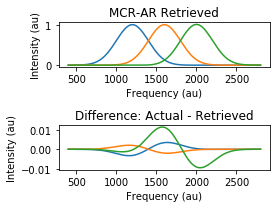

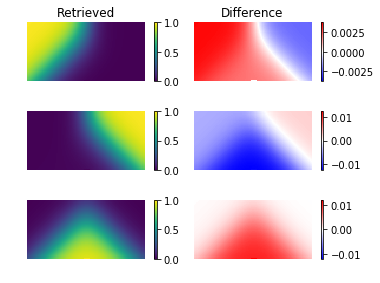

In [9]:
plt.figure(figsize=(6,4))
# plt.subplot(221)
# plt.plot(wn, initial_spectra.T)
# plt.xlabel('Frequency (au)')
# plt.ylabel('Intensity (au)')
# plt.title('Initial Guess')

# plt.subplot(222)
# plt.plot(wn, spectra.T)
# plt.xlabel('Frequency (au)')
# plt.ylabel('Intensity (au)')
# plt.title('Actual')

plt.figure(figsize=(4,3))
plt.subplot(211)
plt.plot(wn, mcrar.ST_opt_.T)
plt.xlabel('Frequency (au)')
plt.ylabel('Intensity (au)')
plt.title('MCR-AR Retrieved')

plt.subplot(212)
plt.plot(wn, spectra.T - mcrar.ST_opt_.T)
plt.xlabel('Frequency (au)')
plt.ylabel('Intensity (au)')
plt.title('Difference: Actual - Retrieved')

plt.tight_layout()
plt.savefig('NJRes_NNLS_NNLS_Spectra.eps')
plt.show()

temp = mcrar.C_opt_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,2,2*num+1)
    
#     plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num], clim=[0,1])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,2,2*num+2)
    temp_differ = conc[...,num] - temp[...,num]
    temp_max_differ = np.abs(temp_differ).max()
    plt.imshow(temp_differ, cmap='bwr', clim=[-temp_max_differ, temp_max_differ])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')
        
plt.tight_layout(w_pad=-5)
plt.savefig('NJRes_NNLS_NNLS_Conc.eps')
plt.show()

# Perform MCR-AR (NNLS) with Non-Negativity, Sum-to-One Constraints, and Enforce Gaussian Spectra

## With spectral guess

In [17]:
from pymcr.constraints import Constraint
from lmfit.models import GaussianModel

class ConstraintSingleGauss(Constraint):
    """
    Perform a nonlinear least-squares fitting to enforce a Gaussian. 

    Parameters
    ----------
    copy : bool
        Make copy of input data, A; otherwise, overwrite (if mutable)
        
    axis : int
            Axis to perform fitting over
            
    """
    def __init__(self, copy=False, axis=-1):
        """ A must be non-negative"""
        self.copy = copy
        self.axis = axis
        
    def transform(self, A):
        """ Fit """
        n_components = list(A.shape)
        x = np.arange(n_components[self.axis])
        n_components.pop(self.axis)
        assert len(n_components)==1, "Input must be 2D"
        n_components = n_components[0]
        
        A_fit = 0*A
        
        for num in range(n_components):
            if (self.axis == -1) | (self.axis == 1):
                y = A[num, :]
            else:
                y = A[:, num]
                
            mod = GaussianModel()
            pars = mod.guess(y, x=x)
            out = mod.fit(y, pars, x=x)
            
            if (self.axis == -1) | (self.axis == 1):
                A_fit[num,:] = 1*out.best_fit
            else:
                A_fit[:, num] = 1*out.best_fit
            
        if self.copy:
            return A_fit
        else:
            A *= 0
            A += A_fit
            return A

In [18]:
mcrar = McrAR(max_iter=1000, st_regr='NNLS', c_regr='NNLS', 
              c_constraints=[ConstraintNorm()],
              st_constraints=[ConstraintSingleGauss()])

mcrar.fit(hsi.reshape((-1, wn.size)), ST=initial_spectra, verbose=True)
print('\nFinal MSE: {:.7e}'.format(mcrar.err[-1]))


Iter: 1 (C)	mse: 2.7181e+05
Iter: 1 (ST)	mse: 6.6426e-04
Iter: 2 (C)	mse: 2.7244e-04
Iter: 2 (ST)	mse: 1.1160e-04
Iter: 3 (C)	mse: 5.6113e-05
Iter: 3 (ST)	mse: 3.0041e-05
Iter: 4 (C)	mse: 1.6736e-05
Iter: 4 (ST)	mse: 1.0173e-05
Iter: 5 (C)	mse: 6.0634e-06
Iter: 5 (ST)	mse: 3.8519e-06
Iter: 6 (C)	mse: 2.4176e-06
Iter: 6 (ST)	mse: 1.5472e-06
Iter: 7 (C)	mse: 1.0196e-06
Iter: 7 (ST)	mse: 6.5217e-07
Iter: 8 (C)	mse: 4.4777e-07
Iter: 8 (ST)	mse: 2.8571e-07
Iter: 9 (C)	mse: 2.0254e-07
Iter: 9 (ST)	mse: 1.2852e-07
Iter: 10 (C)	mse: 9.3370e-08
Iter: 10 (ST)	mse: 5.8866e-08
Iter: 11 (C)	mse: 4.3585e-08
Iter: 11 (ST)	mse: 2.7298e-08
Iter: 12 (C)	mse: 2.0510e-08
Iter: 12 (ST)	mse: 1.2765e-08
Iter: 13 (C)	mse: 9.7023e-09
Iter: 13 (ST)	mse: 6.0035e-09
Iter: 14 (C)	mse: 4.6050e-09
Iter: 14 (ST)	mse: 2.8339e-09
Iter: 15 (C)	mse: 2.1899e-09
Iter: 15 (ST)	mse: 1.3407e-09
Iter: 16 (C)	mse: 1.0422e-09
Iter: 16 (ST)	mse: 6.3499e-10
Iter: 17 (C)	mse: 4.9603e-10
Iter: 17 (ST)	mse: 3.0093e-10
Iter: 18 (C)	ms

# Plotting Results

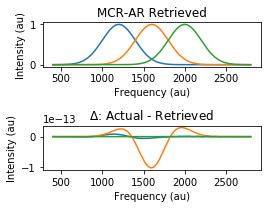

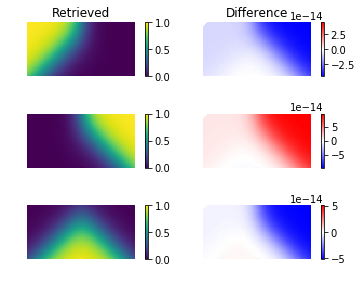

In [19]:
# plt.figure(figsize=(6,4))
# plt.subplot(221)
# plt.plot(wn, initial_spectra.T)
# plt.xlabel('Frequency (au)')
# plt.ylabel('Intensity (au)')
# plt.title('Initial Guess')

# plt.subplot(222)
# plt.plot(wn, spectra.T)
# plt.xlabel('Frequency (au)')
# plt.ylabel('Intensity (au)')
# plt.title('Actual')

plt.figure(figsize=(4,3))
plt.subplot(211)
plt.plot(wn, mcrar.ST_opt_.T)
plt.xlabel('Frequency (au)')
plt.ylabel('Intensity (au)')
plt.title('MCR-AR Retrieved')

plt.subplot(212)
plt.plot(wn, spectra.T - mcrar.ST_opt_.T)
plt.xlabel('Frequency (au)')
plt.ylabel('Intensity (au)')
plt.title('$\Delta$: Actual - Retrieved')

plt.tight_layout()
# plt.axis(ymin=-1e-4, ymax=1e-4 )
plt.savefig('NJRes_NNLS_Gaussian_Spectra.eps')
plt.show()

temp = mcrar.C_opt_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,2,2*num+1)
    
#     plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num], clim=[0,1])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,2,2*num+2)
    temp_differ = conc[...,num] - temp[...,num]
    temp_max_differ = np.abs(temp_differ).max()
#     if temp_max_differ < 1e-4:
#         temp_max_differ = 1e-4
    plt.imshow(temp_differ, cmap='bwr', clim=[-temp_max_differ, temp_max_differ])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')
        
plt.tight_layout(w_pad=-5)
plt.savefig('NJRes_NNLS_Gaussian_Conc.eps')
plt.show()

# Perform MCR-AR with Ridge Regression with Non-Negativity and Sum-to-One Constraints


In [39]:
from sklearn.linear_model import LinearRegression

In [52]:
mcrar = McrAR(max_iter=1000, tol_increase=1.0, st_regr=Ridge(alpha=0.01, fit_intercept=False), c_regr='NNLS', 
              c_constraints=[ConstraintNorm()],
              st_constraints=[ConstraintNonneg()])

mcrar.fit(hsi.reshape((-1, wn.size)), ST=initial_spectra, verbose=True)
print('\nFinal MSE: {:.7e}'.format(mcrar.err[-1]))


Iter: 1 (C)	mse: 2.7181e+05
Iter: 1 (ST)	mse: 4.1900e-04
Iter: 2 (C)	mse: 1.4721e-04
Iter: 2 (ST)	mse: 7.5020e-05
Iter: 3 (C)	mse: 5.2334e-05
Iter: 3 (ST)	mse: 3.8982e-05
Iter: 4 (C)	mse: 2.9836e-05
Iter: 4 (ST)	mse: 2.3570e-05
Iter: 5 (C)	mse: 1.8729e-05
Iter: 5 (ST)	mse: 1.5326e-05
Iter: 6 (C)	mse: 1.2508e-05
Iter: 6 (ST)	mse: 1.0506e-05
Iter: 7 (C)	mse: 8.7599e-06
Iter: 7 (ST)	mse: 7.5149e-06
Iter: 8 (C)	mse: 6.3775e-06
Iter: 8 (ST)	mse: 5.5691e-06
Iter: 9 (C)	mse: 4.7972e-06
Iter: 9 (ST)	mse: 4.2511e-06
Iter: 10 (C)	mse: 3.7086e-06
Iter: 10 (ST)	mse: 3.3275e-06
Iter: 11 (C)	mse: 2.9349e-06
Iter: 11 (ST)	mse: 2.6622e-06
Iter: 12 (C)	mse: 2.3707e-06
Iter: 12 (ST)	mse: 2.1695e-06
Iter: 13 (C)	mse: 1.9475e-06
Iter: 13 (ST)	mse: 1.7966e-06
Iter: 14 (C)	mse: 1.6252e-06
Iter: 14 (ST)	mse: 1.5098e-06
Iter: 15 (C)	mse: 1.3744e-06
Iter: 15 (ST)	mse: 1.2840e-06
Iter: 16 (C)	mse: 1.1755e-06
Iter: 16 (ST)	mse: 1.1038e-06
Iter: 17 (C)	mse: 1.0157e-06
Iter: 17 (ST)	mse: 9.5813e-07
Iter: 18 (C)	ms

Iter: 139 (C)	mse: 1.5081e-08
Iter: 139 (ST)	mse: 1.5028e-08
Iter: 140 (C)	mse: 1.4893e-08
Iter: 140 (ST)	mse: 1.4841e-08
Iter: 141 (C)	mse: 1.4708e-08
Iter: 141 (ST)	mse: 1.4656e-08
Iter: 142 (C)	mse: 1.4526e-08
Iter: 142 (ST)	mse: 1.4476e-08
Iter: 143 (C)	mse: 1.4347e-08
Iter: 143 (ST)	mse: 1.4298e-08
Iter: 144 (C)	mse: 1.4172e-08
Iter: 144 (ST)	mse: 1.4123e-08
Iter: 145 (C)	mse: 1.3999e-08
Iter: 145 (ST)	mse: 1.3952e-08
Iter: 146 (C)	mse: 1.3830e-08
Iter: 146 (ST)	mse: 1.3783e-08
Iter: 147 (C)	mse: 1.3663e-08
Iter: 147 (ST)	mse: 1.3617e-08
Iter: 148 (C)	mse: 1.3499e-08
Iter: 148 (ST)	mse: 1.3454e-08
Iter: 149 (C)	mse: 1.3338e-08
Iter: 149 (ST)	mse: 1.3293e-08
Iter: 150 (C)	mse: 1.3179e-08
Iter: 150 (ST)	mse: 1.3135e-08
Iter: 151 (C)	mse: 1.3023e-08
Iter: 151 (ST)	mse: 1.2980e-08
Iter: 152 (C)	mse: 1.2870e-08
Iter: 152 (ST)	mse: 1.2827e-08
Iter: 153 (C)	mse: 1.2719e-08
Iter: 153 (ST)	mse: 1.2677e-08
Iter: 154 (C)	mse: 1.2571e-08
Iter: 154 (ST)	mse: 1.2530e-08
Iter: 155 (C)	mse: 1.242

Iter: 275 (C)	mse: 4.2387e-09
Iter: 275 (ST)	mse: 4.2313e-09
Iter: 276 (C)	mse: 4.2097e-09
Iter: 276 (ST)	mse: 4.2025e-09
Iter: 277 (C)	mse: 4.1810e-09
Iter: 277 (ST)	mse: 4.1739e-09
Iter: 278 (C)	mse: 4.1526e-09
Iter: 278 (ST)	mse: 4.1456e-09
Iter: 279 (C)	mse: 4.1245e-09
Iter: 279 (ST)	mse: 4.1176e-09
Iter: 280 (C)	mse: 4.0967e-09
Iter: 280 (ST)	mse: 4.0899e-09
Iter: 281 (C)	mse: 4.0692e-09
Iter: 281 (ST)	mse: 4.0624e-09
Iter: 282 (C)	mse: 4.0420e-09
Iter: 282 (ST)	mse: 4.0352e-09
Iter: 283 (C)	mse: 4.0150e-09
Iter: 283 (ST)	mse: 4.0084e-09
Iter: 284 (C)	mse: 3.9883e-09
Iter: 284 (ST)	mse: 3.9817e-09
Iter: 285 (C)	mse: 3.9619e-09
Iter: 285 (ST)	mse: 3.9554e-09
Iter: 286 (C)	mse: 3.9357e-09
Iter: 286 (ST)	mse: 3.9293e-09
Iter: 287 (C)	mse: 3.9098e-09
Iter: 287 (ST)	mse: 3.9035e-09
Iter: 288 (C)	mse: 3.8842e-09
Iter: 288 (ST)	mse: 3.8779e-09
Iter: 289 (C)	mse: 3.8588e-09
Iter: 289 (ST)	mse: 3.8526e-09
Iter: 290 (C)	mse: 3.8337e-09
Iter: 290 (ST)	mse: 3.8276e-09
Iter: 291 (C)	mse: 3.808

Iter: 411 (C)	mse: 2.0448e-09
Iter: 411 (ST)	mse: 2.0439e-09
Iter: 412 (C)	mse: 2.0362e-09
Iter: 412 (ST)	mse: 2.0353e-09
Iter: 413 (C)	mse: 2.0277e-09
Iter: 413 (ST)	mse: 2.0268e-09
Iter: 414 (C)	mse: 2.0193e-09
Iter: 414 (ST)	mse: 2.0184e-09
Iter: 415 (C)	mse: 2.0109e-09
Iter: 415 (ST)	mse: 2.0100e-09
Iter: 416 (C)	mse: 2.0026e-09
Iter: 416 (ST)	mse: 2.0017e-09
Iter: 417 (C)	mse: 1.9943e-09
Iter: 417 (ST)	mse: 1.9935e-09
Iter: 418 (C)	mse: 1.9861e-09
Iter: 418 (ST)	mse: 1.9853e-09
Iter: 419 (C)	mse: 1.9780e-09
Iter: 419 (ST)	mse: 1.9772e-09
Iter: 420 (C)	mse: 1.9699e-09
Iter: 420 (ST)	mse: 1.9691e-09
Iter: 421 (C)	mse: 1.9618e-09
Iter: 421 (ST)	mse: 1.9611e-09
Iter: 422 (C)	mse: 1.9538e-09
Iter: 422 (ST)	mse: 1.9531e-09
Iter: 423 (C)	mse: 1.9459e-09
Iter: 423 (ST)	mse: 1.9452e-09
Iter: 424 (C)	mse: 1.9380e-09
Iter: 424 (ST)	mse: 1.9373e-09
Iter: 425 (C)	mse: 1.9302e-09
Iter: 425 (ST)	mse: 1.9295e-09
Iter: 426 (C)	mse: 1.9225e-09
Iter: 426 (ST)	mse: 1.9218e-09
Iter: 427 (C)	mse: 1.914

Iter: 547 (C)	mse: 1.2735e-09
Iter: 547 (ST)	mse: 1.2741e-09
Iter: 548 (C)	mse: 1.2698e-09
Iter: 548 (ST)	mse: 1.2703e-09
Iter: 549 (C)	mse: 1.2660e-09
Iter: 549 (ST)	mse: 1.2666e-09
Iter: 550 (C)	mse: 1.2624e-09
Iter: 550 (ST)	mse: 1.2630e-09
Iter: 551 (C)	mse: 1.2587e-09
Iter: 551 (ST)	mse: 1.2593e-09
Iter: 552 (C)	mse: 1.2550e-09
Iter: 552 (ST)	mse: 1.2557e-09
Iter: 553 (C)	mse: 1.2514e-09
Iter: 553 (ST)	mse: 1.2520e-09
Iter: 554 (C)	mse: 1.2478e-09
Iter: 554 (ST)	mse: 1.2484e-09
Iter: 555 (C)	mse: 1.2442e-09
Iter: 555 (ST)	mse: 1.2448e-09
Iter: 556 (C)	mse: 1.2406e-09
Iter: 556 (ST)	mse: 1.2413e-09
Iter: 557 (C)	mse: 1.2371e-09
Iter: 557 (ST)	mse: 1.2377e-09
Iter: 558 (C)	mse: 1.2335e-09
Iter: 558 (ST)	mse: 1.2342e-09
Iter: 559 (C)	mse: 1.2300e-09
Iter: 559 (ST)	mse: 1.2306e-09
Iter: 560 (C)	mse: 1.2265e-09
Iter: 560 (ST)	mse: 1.2271e-09
Iter: 561 (C)	mse: 1.2230e-09
Iter: 561 (ST)	mse: 1.2237e-09
Iter: 562 (C)	mse: 1.2195e-09
Iter: 562 (ST)	mse: 1.2202e-09
Iter: 563 (C)	mse: 1.216

Iter: 683 (C)	mse: 8.9839e-10
Iter: 683 (ST)	mse: 8.9938e-10
Iter: 684 (C)	mse: 8.9637e-10
Iter: 684 (ST)	mse: 8.9736e-10
Iter: 685 (C)	mse: 8.9436e-10
Iter: 685 (ST)	mse: 8.9535e-10
Iter: 686 (C)	mse: 8.9235e-10
Iter: 686 (ST)	mse: 8.9334e-10
Iter: 687 (C)	mse: 8.9035e-10
Iter: 687 (ST)	mse: 8.9134e-10
Iter: 688 (C)	mse: 8.8836e-10
Iter: 688 (ST)	mse: 8.8935e-10
Iter: 689 (C)	mse: 8.8637e-10
Iter: 689 (ST)	mse: 8.8736e-10
Iter: 690 (C)	mse: 8.8439e-10
Iter: 690 (ST)	mse: 8.8538e-10
Iter: 691 (C)	mse: 8.8241e-10
Iter: 691 (ST)	mse: 8.8341e-10
Iter: 692 (C)	mse: 8.8045e-10
Iter: 692 (ST)	mse: 8.8144e-10
Iter: 693 (C)	mse: 8.7848e-10
Iter: 693 (ST)	mse: 8.7948e-10
Iter: 694 (C)	mse: 8.7653e-10
Iter: 694 (ST)	mse: 8.7753e-10
Iter: 695 (C)	mse: 8.7458e-10
Iter: 695 (ST)	mse: 8.7558e-10
Iter: 696 (C)	mse: 8.7264e-10
Iter: 696 (ST)	mse: 8.7364e-10
Iter: 697 (C)	mse: 8.7070e-10
Iter: 697 (ST)	mse: 8.7170e-10
Iter: 698 (C)	mse: 8.6877e-10
Iter: 698 (ST)	mse: 8.6977e-10
Iter: 699 (C)	mse: 8.668

Iter: 819 (C)	mse: 6.7489e-10
Iter: 819 (ST)	mse: 6.7592e-10
Iter: 820 (C)	mse: 6.7358e-10
Iter: 820 (ST)	mse: 6.7462e-10
Iter: 821 (C)	mse: 6.7228e-10
Iter: 821 (ST)	mse: 6.7332e-10
Iter: 822 (C)	mse: 6.7099e-10
Iter: 822 (ST)	mse: 6.7203e-10
Iter: 823 (C)	mse: 6.6970e-10
Iter: 823 (ST)	mse: 6.7075e-10
Iter: 824 (C)	mse: 6.6842e-10
Iter: 824 (ST)	mse: 6.6946e-10
Iter: 825 (C)	mse: 6.6714e-10
Iter: 825 (ST)	mse: 6.6819e-10
Iter: 826 (C)	mse: 6.6587e-10
Iter: 826 (ST)	mse: 6.6692e-10
Iter: 827 (C)	mse: 6.6460e-10
Iter: 827 (ST)	mse: 6.6565e-10
Iter: 828 (C)	mse: 6.6334e-10
Iter: 828 (ST)	mse: 6.6439e-10
Iter: 829 (C)	mse: 6.6208e-10
Iter: 829 (ST)	mse: 6.6313e-10
Iter: 830 (C)	mse: 6.6083e-10
Iter: 830 (ST)	mse: 6.6188e-10
Iter: 831 (C)	mse: 6.5958e-10
Iter: 831 (ST)	mse: 6.6063e-10
Iter: 832 (C)	mse: 6.5834e-10
Iter: 832 (ST)	mse: 6.5939e-10
Iter: 833 (C)	mse: 6.5710e-10
Iter: 833 (ST)	mse: 6.5814e-10
Iter: 834 (C)	mse: 6.5586e-10
Iter: 834 (ST)	mse: 6.5691e-10
Iter: 835 (C)	mse: 6.546

Iter: 955 (C)	mse: 5.3070e-10
Iter: 955 (ST)	mse: 5.3174e-10
Iter: 956 (C)	mse: 5.2981e-10
Iter: 956 (ST)	mse: 5.3085e-10
Iter: 957 (C)	mse: 5.2892e-10
Iter: 957 (ST)	mse: 5.2996e-10
Iter: 958 (C)	mse: 5.2803e-10
Iter: 958 (ST)	mse: 5.2907e-10
Iter: 959 (C)	mse: 5.2714e-10
Iter: 959 (ST)	mse: 5.2818e-10
Iter: 960 (C)	mse: 5.2626e-10
Iter: 960 (ST)	mse: 5.2730e-10
Iter: 961 (C)	mse: 5.2537e-10
Iter: 961 (ST)	mse: 5.2641e-10
Iter: 962 (C)	mse: 5.2449e-10
Iter: 962 (ST)	mse: 5.2553e-10
Iter: 963 (C)	mse: 5.2361e-10
Iter: 963 (ST)	mse: 5.2465e-10
Iter: 964 (C)	mse: 5.2274e-10
Iter: 964 (ST)	mse: 5.2377e-10
Iter: 965 (C)	mse: 5.2186e-10
Iter: 965 (ST)	mse: 5.2290e-10
Iter: 966 (C)	mse: 5.2099e-10
Iter: 966 (ST)	mse: 5.2202e-10
Iter: 967 (C)	mse: 5.2012e-10
Iter: 967 (ST)	mse: 5.2115e-10
Iter: 968 (C)	mse: 5.1925e-10
Iter: 968 (ST)	mse: 5.2028e-10
Iter: 969 (C)	mse: 5.1838e-10
Iter: 969 (ST)	mse: 5.1942e-10
Iter: 970 (C)	mse: 5.1752e-10
Iter: 970 (ST)	mse: 5.1855e-10
Iter: 971 (C)	mse: 5.166

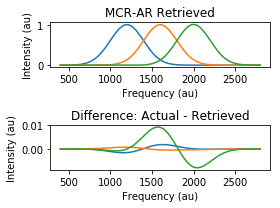

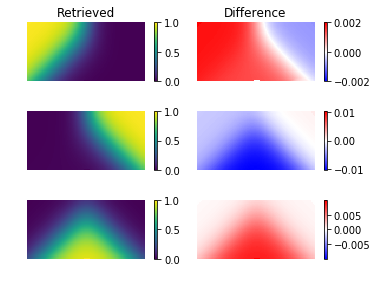

In [55]:
# plt.figure(figsize=(6,4))
# plt.subplot(221)
# plt.plot(wn, initial_spectra.T)
# plt.xlabel('Frequency (au)')
# plt.ylabel('Intensity (au)')
# plt.title('Initial Guess')

# plt.subplot(222)
# plt.plot(wn, spectra.T)
# plt.xlabel('Frequency (au)')
# plt.ylabel('Intensity (au)')
# plt.title('Actual')

plt.figure(figsize=(4,3))
plt.subplot(211)
plt.plot(wn, mcrar.ST_opt_.T)
plt.xlabel('Frequency (au)')
plt.ylabel('Intensity (au)')
plt.title('MCR-AR Retrieved')

plt.subplot(212)
plt.plot(wn, spectra.T - mcrar.ST_opt_.T)
plt.xlabel('Frequency (au)')
plt.ylabel('Intensity (au)')
plt.title('Difference: Actual - Retrieved')

plt.tight_layout()
# plt.axis(ymin=-1e-4, ymax=1e-4 )
plt.savefig('NJRes_Ridge_Spectra.eps')
plt.show()

temp = mcrar.C_opt_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,2,2*num+1)
    
#     plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num], clim=[0,1])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,2,2*num+2)
    temp_differ = conc[...,num] - temp[...,num]
    temp_max_differ = np.abs(temp_differ).max()
#     if temp_max_differ < 1e-4:
#         temp_max_differ = 1e-4
    plt.imshow(temp_differ, cmap='bwr', clim=[-temp_max_differ, temp_max_differ])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')
        
plt.tight_layout(w_pad=-5)
plt.savefig('NJRes_Ridge_Conc.eps')
plt.show()